In [57]:
NUMBER_OF_EPOCH = 10000
# num_of_categories = 

In [58]:
import torch
import torch.nn as nn
import pandas as pd
import math
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
elif torch.backends.cuda.is_built():
    mps_device = torch.device("cuda")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")
    

tensor([1.], device='cuda:0')


In [59]:
def prepare_model(df):
    
    # df = pre.standardize(df)
    # df = pre.encoder(df)
    # df = df.drop(['id'], axis=1)

    from sklearn.model_selection import train_test_split
    train, val = train_test_split(df, test_size=0.05)

    y_train = torch.tensor(train['price'].values, dtype=torch.float32)
    X_train = train.drop(['price'], axis=1)
    X_train = torch.tensor(X_train.values, dtype=torch.float32)

    y_val = torch.tensor(val['price'].values, dtype=torch.float32)
    X_val = val.drop(['price'], axis=1)
    X_val = torch.tensor(X_val.values, dtype=torch.float32)
        
    return X_train, y_train, X_val, y_val

In [60]:
# Define model
class mlp(nn.Module):
    def __init__(self):
        super(mlp, self).__init__()
        
        self.layers = nn.Sequential(
        nn.Linear(8, 256),
        nn.Dropout(0.1),
        nn.ReLU(), 
        
        nn.Linear(256, 64),
        nn.ReLU(),

        nn.Linear(64, 1)
        )
        
        self.model_layer = nn.Sequential(
        nn.Linear(149, 1),
        nn.ReLU()
        )
        
        self.gear_box_layer = nn.Sequential(
        nn.Linear(3, 1),
        nn.ReLU()
        )
        
        self.fuel_type_layer = nn.Sequential( 
        nn.Linear(4, 1),
        nn.ReLU()
        )
        
        # self.registration_fee_layer = nn.Sequential(
        # nn.Linear(8, 1),
        # nn.ReLU()
        # )
        
        # self.engine_capacity_layer = nn.Sequential(
        # nn.Linear(10, 1),
        # nn.ReLU()
        # )
    
        
    def forward(self, x):
        # print(x.shape)
        model = self.model_layer(x[:, 5:154])
        gear_box = self.gear_box_layer(x[:, 154:157])
        fuel_type = self.fuel_type_layer(x[:, 157:161])
        
        # registration_fee = self.registration_fee_layer(x[:, 156:164])
        # engine_capacity = self.engine_capacity_layer(x[:, 164:174])
        # operating_hours = x[:, 174].view(-1, 1)
        # year = x[:, 175].view(-1, 1)
        # efficiency = x[:, 176].view(-1, 1)

        
        # x = torch.cat((model, year, gear_box, operating_hours, fuel_type, registration_fee, efficiency, engine_capacity), 1)
        
        x = torch.cat((model, gear_box, fuel_type, x[:, :5]), 1)
        
        return self.layers(x)

model = mlp()
model

mlp(
  (layers): Sequential(
    (0): Linear(in_features=8, out_features=256, bias=True)
    (1): Dropout(p=0.1, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): ReLU()
    (5): Linear(in_features=64, out_features=1, bias=True)
  )
  (model_layer): Sequential(
    (0): Linear(in_features=149, out_features=1, bias=True)
    (1): ReLU()
  )
  (gear_box_layer): Sequential(
    (0): Linear(in_features=3, out_features=1, bias=True)
    (1): ReLU()
  )
  (fuel_type_layer): Sequential(
    (0): Linear(in_features=4, out_features=1, bias=True)
    (1): ReLU()
  )
)

In [61]:
class RMSELoss(nn.Module):
    def __init__(self):
        super(RMSELoss, self).__init__()
        self.mse = nn.MSELoss()

    def forward(self, y_pred, y_true):
        return torch.sqrt(self.mse(y_pred, y_true))

In [62]:
loss_fn = RMSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-3)

In [63]:
df = pd.read_csv('data/train.csv')
X_train, y_train, X_val, y_val = prepare_model(df)
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

torch.Size([9025, 161]) torch.Size([9025]) torch.Size([475, 161]) torch.Size([475])


In [64]:
import numpy as np 
best_val_loss = float('inf')
training_loss = np.array([])
validation_loss = np.array([])
last_val_loss = float('inf')
count = 0
for n in range(NUMBER_OF_EPOCH):
    model.train()
    y_pred = model(X_train)[:, 0]
    loss = loss_fn(y_pred, y_train)
    training_loss = np.append(training_loss, loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    model.eval()
    y_pred = model(X_val)[:, 0]
    val_loss = loss_fn(y_pred, y_val)
    validation_loss = np.append(validation_loss, val_loss.item())
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        # torch.save(model, 'mlp_model.pth')
    if n % 100 == 0:
        print(f'Epoch: {n} Loss: {loss.item()}'f' Validation loss: {val_loss.item()}'f' best Validation loss: {best_val_loss}')
        
    if last_val_loss < val_loss:
        count += 1
        if count == 25:
            break
    else:
        count = 0
    last_val_loss = val_loss
    
torch.save(model, 'mlp_model.pth')

Epoch: 0 Loss: 18203.15625 Validation loss: 18419.837890625 best Validation loss: 18419.837890625
Epoch: 100 Loss: 18108.431640625 Validation loss: 18320.22265625 best Validation loss: 18320.22265625
Epoch: 200 Loss: 17003.865234375 Validation loss: 17160.501953125 best Validation loss: 17160.501953125
Epoch: 300 Loss: 11987.6376953125 Validation loss: 11896.6318359375 best Validation loss: 11896.6318359375
Epoch: 400 Loss: 4519.8720703125 Validation loss: 4389.13330078125 best Validation loss: 4389.13330078125
Epoch: 500 Loss: 3640.39404296875 Validation loss: 3657.712890625 best Validation loss: 3657.712890625
Epoch: 600 Loss: 3297.81640625 Validation loss: 3396.5478515625 best Validation loss: 3396.5478515625
Epoch: 700 Loss: 3116.251953125 Validation loss: 3209.1484375 best Validation loss: 3209.1484375
Epoch: 800 Loss: 2950.6748046875 Validation loss: 3053.260986328125 best Validation loss: 3053.260986328125
Epoch: 900 Loss: 2843.57080078125 Validation loss: 2921.6630859375 best V

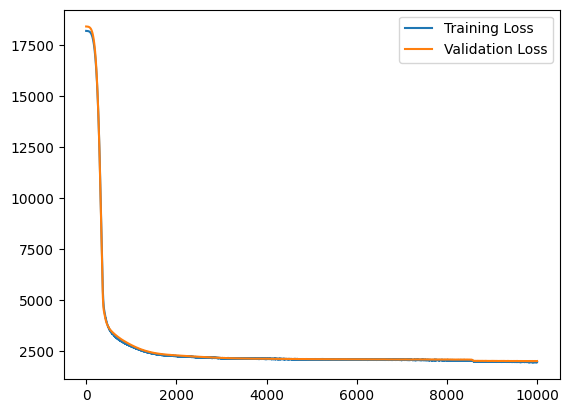

In [65]:
import matplotlib.pyplot as plt

plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.legend(loc='best')

In [66]:
import pickle

df = pd.read_csv('data/test.csv')
model = torch.load('mlp_model.pth')
model.eval()

index = df['id']
# X = pre.encoder(df)
# X = pre.standardize(X, scaler=pickle.load(open('scaler.pkl', 'rb')))
X = df.drop(['id'], axis=1)
X = torch.tensor(X.values, dtype=torch.float32)
y_pred = model(X)[:, 0]

df = pd.DataFrame(y_pred.detach().numpy(), columns=['price'])
df = pd.concat([index, df], axis=1)
df.rename(columns={'price': 'answer'}, inplace=True)
df.to_csv('output.csv', index=False)

/tmp/ipykernel_6045/405736231.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('mlp_model.pth')
